<a href="https://colab.research.google.com/github/shlokashah/Emotion-Recognition-with-BERT/blob/master/Emotion_Recognition_with_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
%matplotlib inline

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")

In [ ]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()  
data['sentiment']= label_encoder.fit_transform(data['emotion']) 

In [ ]:
data.head()

,sentence,emotion,sentiment
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [ ]:
data.shape

(20000, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   20000 non-null  object
 1   emotion    20000 non-null  object
 2   sentiment  20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


Text(0.5, 0, 'emotion')

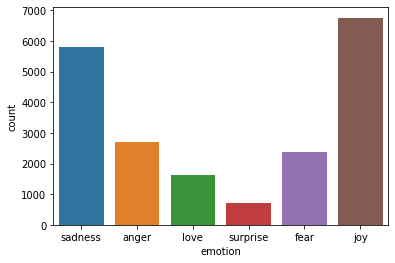

In [ ]:
sns.countplot(data.emotion)
plt.xlabel('emotion')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []
for txt in data.sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

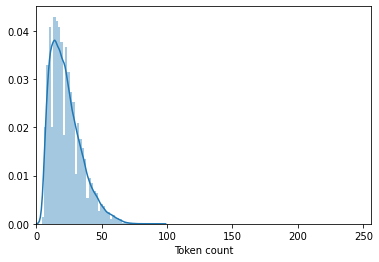

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

94

In [ ]:
MAX_LEN = 94

In [ ]:
class Emotion(Dataset):
  def __init__(self, sentence, sentiment, tokenizer, max_len):
    self.sentence = sentence
    self.sentiment = sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.sentence)

  def __getitem__(self, item):
    sentences= str(self.sentence[item])
    sentiment = self.sentiment[item]
    
    encoding = self.tokenizer.encode_plus(
      sentences,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'sentence': sentences,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiment': torch.tensor(sentiment, dtype=torch.long)
    }

In [ ]:
data_train, data_test = train_test_split(
  data,
  test_size=0.1,
  random_state=RANDOM_SEED
)
data_val, data_test = train_test_split(
  data_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
print(data_train.shape, data_val.shape, data_test.shape)

(18000, 3) (1000, 3) (1000, 3)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Emotion(
    sentence=df.sentence.to_numpy(),
    sentiment=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
df = next(iter(train_data_loader))
df.keys()

dict_keys(['sentence', 'input_ids', 'attention_mask', 'sentiment'])

In [ ]:
print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['sentiment'].shape)

torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(data['emotion'].unique()))
model = model.to(device)
# len(data['emotion'].unique())

In [ ]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [ ]:
print(input_ids.shape) 
print(attention_mask.shape)

torch.Size([16, 94])
torch.Size([16, 94])


In [ ]:
# F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiment = d["sentiment"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiment)

    correct_predictions += torch.sum(preds == sentiment)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiment = d["sentiment"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiment)

      correct_predictions += torch.sum(preds == sentiment)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(data_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(data_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/best_model_state.h5')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.19194584970341788 accuracy 0.9293333333333333
Val   loss 0.11742823086087666 accuracy 0.9430000000000001

Epoch 2/10
----------
Train loss 0.12490676799747678 accuracy 0.9475
Val   loss 0.1479513713764766 accuracy 0.9380000000000001

Epoch 3/10
----------
Train loss 0.09663645861546198 accuracy 0.9607777777777778
Val   loss 0.17171635277687558 accuracy 0.9380000000000001

Epoch 4/10
----------
Train loss 0.07514324941237767 accuracy 0.9712222222222223
Val   loss 0.19408030595098222 accuracy 0.9390000000000001

Epoch 5/10
----------
Train loss 0.05877907025814057 accuracy 0.9818888888888889
Val   loss 0.284483869397451 accuracy 0.9390000000000001

Epoch 6/10
----------
Train loss 0.04166535207960341 accuracy 0.988388888888889
Val   loss 0.3140042715129398 accuracy 0.9390000000000001

Epoch 7/10
----------
Train loss 0.031104056888156466 accuracy 0.992
Val   loss 0.3577551512964188 accuracy 0.9420000000000001

Epoch 8/10
----------
Train loss 0.02346092

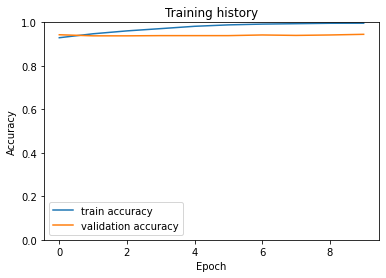

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(data_test)
)
test_acc.item()

0.936

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentences = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["sentence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiment"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(sentiments)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentences, predictions, prediction_probs, real_values

In [ ]:
y_sentence_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=data['emotion'].unique()))

              precision    recall  f1-score   support

     sadness       0.94      0.92      0.93       131
       anger       0.88      0.89      0.88       131
        love       0.97      0.95      0.96       354
    surprise       0.83      0.88      0.85        72
        fear       0.95      0.98      0.97       269
         joy       0.90      0.84      0.87        43

    accuracy                           0.94      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.94      0.94      0.94      1000



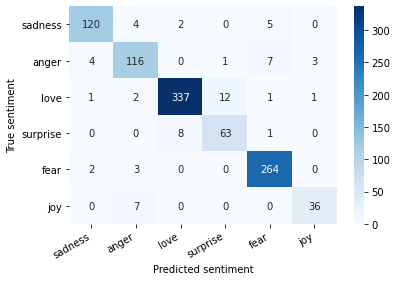

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=data['emotion'].unique(), columns=data['emotion'].unique())
show_confusion_matrix(df_cm)

In [ ]:
idx = 19
sentence_text = y_sentence_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'emotion': data['emotion'].unique(),
  'values': y_pred_probs[idx]
})
pred_df

,emotion,values
0,sadness,-1.014900
1,anger,-1.538664
2,love,-1.641535
3,surprise,-2.445553
4,fear,10.491877
5,joy,-1.410815


In [ ]:
print("\n".join(wrap(sentence_text)))
print()
print(f'True sentiment: {true_sentiment}')

i feel excluded and worthless my connection to everyone summarily cut
off

True sentiment: 4


In [ ]:
class_names=['sadness','anger','love','suprise','fear','joy']

In [ ]:
review_text = "When things go wrong as they sometime will, when roads you are trudging see all uphill. When funds are high and depth are low. When you want to smile but you have to sigh. When all is pressing you down a bit, rest if you must but don't you quit."

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: When things go wrong as they sometime will, when roads you are trudging see all uphill. When funds are high and depth are low. When you want to smile but you have to sigh. When all is pressing you down a bit, rest if you must but don't you quit.
Sentiment: anger


In [ ]:
review_text = 'My life is beautiful because of you my love.You showed me the meaning of love not with your words but with your care.speak up the love you have for me.Love you a lot.'

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: My life is beautiful because of you my love.You showed me the meaning of love not with your words but with your care.speak up the love you have for me.Love you a lot.
Sentiment: suprise


In [ ]:
review_text = 'The woods are lovely, dark and deep, But I have promises to keep, And miles to go before I sleep, And miles to go before I sleep'

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: The woods are lovely, dark and deep, But I have promises to keep, And miles to go before I sleep, And miles to go before I sleep
Sentiment: suprise


In [ ]:
review_text = 'Such an amazing day today. I am very happy'

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment: {class_names[prediction]}')

Review text: Such an amazing day today. I am very happy
Sentiment: love
